## Variant 1: Change the ReLU activation functions to SELU and Swish. Would the performance improve?

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torch.utils.data.dataset import Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
""" A dataset wrapper class for applying transforms on the fly. """

class TransformDataset(Dataset):
    
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
full_train_set = datasets.CIFAR10(root='./data', train=True, download=True)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the full training dataset into new training and validation datasets (80/20 split)
train_size = int(0.8 * len(full_train_set))
val_size = len(full_train_set) - train_size
train_indices, val_indices = torch.utils.data.random_split(range(len(full_train_set)), [train_size, val_size])

train_dataset = TransformDataset(Subset(full_train_set, train_indices), transform=transform_train)
val_dataset = TransformDataset(Subset(full_train_set, val_indices), transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## SELU Activation Function

In [4]:
class MiniVGGSelu(nn.Module):
    def __init__(self):
        super(MiniVGGSelu, self).__init__()

        # First convolutional block
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)  # Second FC layer

    def forward(self, x):
        # Each convolutional block followed by pooling
        x = F.selu(self.bn1_1(self.conv1_1(x)))
        x = self.pool1(F.selu(self.bn1_2(self.conv1_2(x))))

        x = F.selu(self.bn2_1(self.conv2_1(x)))
        x = self.pool2(F.selu(self.bn2_2(self.conv2_2(x))))

        x = F.selu(self.bn3_1(self.conv3_1(x)))
        x = self.pool3(F.selu(self.bn3_2(self.conv3_2(x))))

        # Flatten and pass through dense layers with dropout in between
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(x)
        x = F.selu(self.fc1(x))
        x = self.fc2(x)

        return x
    
model = MiniVGGSelu()


In [5]:
from torch.optim.lr_scheduler import StepLR

# Loss function and optimizer with weight decay
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0008, weight_decay=0.005)  
scheduler = StepLR(optimizer, step_size= 40 , gamma=0.3)


# Device configuration
device = torch.device("cuda")
model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_samples = 0
        running_loss = 0.0
        running_correct = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_correct / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc * 100)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc * 100)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc * 100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc * 100:.2f}%')
        
        # Update the learning rate
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Start training with scheduler
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100)


Epoch [1/100]: Train Loss: 1.7220, Train Acc: 38.26%, Val Loss: 1.4027, Val Acc: 50.63%
Epoch [2/100]: Train Loss: 1.3948, Train Acc: 50.21%, Val Loss: 1.2349, Val Acc: 56.51%
Epoch [3/100]: Train Loss: 1.2600, Train Acc: 55.28%, Val Loss: 1.1346, Val Acc: 60.03%
Epoch [4/100]: Train Loss: 1.1608, Train Acc: 59.42%, Val Loss: 1.0524, Val Acc: 63.28%
Epoch [5/100]: Train Loss: 1.0911, Train Acc: 61.77%, Val Loss: 1.0332, Val Acc: 64.05%
Epoch [6/100]: Train Loss: 1.0382, Train Acc: 63.64%, Val Loss: 0.9850, Val Acc: 65.51%
Epoch [7/100]: Train Loss: 0.9936, Train Acc: 65.32%, Val Loss: 0.9395, Val Acc: 67.29%
Epoch [8/100]: Train Loss: 0.9663, Train Acc: 66.21%, Val Loss: 0.9166, Val Acc: 67.85%
Epoch [9/100]: Train Loss: 0.9357, Train Acc: 67.46%, Val Loss: 0.9139, Val Acc: 67.91%
Epoch [10/100]: Train Loss: 0.9166, Train Acc: 67.98%, Val Loss: 0.8859, Val Acc: 69.09%
Epoch [11/100]: Train Loss: 0.8914, Train Acc: 68.98%, Val Loss: 0.8451, Val Acc: 70.39%
Epoch [12/100]: Train Loss: 0.

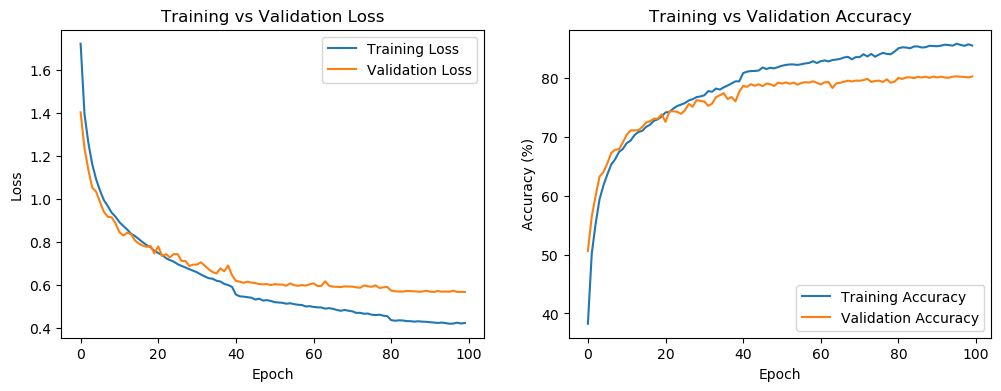

In [6]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # plt.savefig('/home/rushi/Minnie/DL/outputs/output_weight_decay_lr_' + str(weight_decay) + '_' + str(lr) + '.png')
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


#### Test Accuracy for SELU

In [7]:
model.eval()  # Set the model to evaluation mode
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_set)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.8005


### Observation :
For the SELU activation function, the training and validation losses decrease steadily and remain closely aligned, which suggests that the model is generalizing well without significant overfitting. 

Achieved Test Accuracy: 80.05%, which is higher than relu. This suggests that the SELU activation function could potentially yield better generalization.

## Swish Activation Function 

In [4]:
import torch

class MiniVGGSwish(nn.Module):
    def __init__(self):
        super(MiniVGGSwish, self).__init__()

        # First convolutional block
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Second convolutional block
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Third convolutional block
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)  # Second FC layer

    def forward(self, x):
        swish = lambda x: x * torch.sigmoid(x)  # Swish activation function

        # Each convolutional block followed by pooling
        x = swish(self.bn1_1(self.conv1_1(x)))
        x = self.pool1(swish(self.bn1_2(self.conv1_2(x))))

        x = swish(self.bn2_1(self.conv2_1(x)))
        x = self.pool2(swish(self.bn2_2(self.conv2_2(x))))

        x = swish(self.bn3_1(self.conv3_1(x)))
        x = self.pool3(swish(self.bn3_2(self.conv3_2(x))))

        # Flatten and pass through dense layers with dropout in between
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(x)
        x = swish(self.fc1(x))
        x = self.fc2(x)

        return x
    
# Reinitialize the model with the new definition
model = MiniVGGSwish()

In [5]:
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.optim as optim

# Loss function and optimizer with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0008, weight_decay=0.005)  # L2
# Initialize the StepLR scheduler
scheduler = StepLR(optimizer, step_size=20, gamma=0.3)

# Device configuration
device = torch.device("cuda")
model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=80):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_samples = 0
        running_loss = 0.0
        running_correct = 0

        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_correct / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc * 100)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / val_total
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc * 100)

        # Print training and validation results
        print(f'Epoch [{epoch+1}/{num_epochs}]: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc * 100:.2f}%, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc * 100:.2f}%')

        # Update the learning rate
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Start training with scheduler
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=80)

Epoch [1/80]: Train Loss: 1.9957, Train Acc: 30.08%, Val Loss: 1.7314, Val Acc: 40.20%
Epoch [2/80]: Train Loss: 1.5994, Train Acc: 43.71%, Val Loss: 1.4789, Val Acc: 46.79%
Epoch [3/80]: Train Loss: 1.4219, Train Acc: 49.08%, Val Loss: 1.3367, Val Acc: 52.18%
Epoch [4/80]: Train Loss: 1.3014, Train Acc: 53.78%, Val Loss: 1.2421, Val Acc: 55.60%
Epoch [5/80]: Train Loss: 1.2134, Train Acc: 56.84%, Val Loss: 1.1586, Val Acc: 58.82%
Epoch [6/80]: Train Loss: 1.1358, Train Acc: 59.84%, Val Loss: 1.0900, Val Acc: 60.87%
Epoch [7/80]: Train Loss: 1.0626, Train Acc: 62.59%, Val Loss: 1.0237, Val Acc: 63.63%
Epoch [8/80]: Train Loss: 0.9999, Train Acc: 64.75%, Val Loss: 0.9784, Val Acc: 65.38%
Epoch [9/80]: Train Loss: 0.9480, Train Acc: 66.94%, Val Loss: 0.9330, Val Acc: 66.78%
Epoch [10/80]: Train Loss: 0.9013, Train Acc: 68.27%, Val Loss: 0.8770, Val Acc: 69.30%
Epoch [11/80]: Train Loss: 0.8641, Train Acc: 69.88%, Val Loss: 0.8658, Val Acc: 69.48%
Epoch [12/80]: Train Loss: 0.8338, Train 

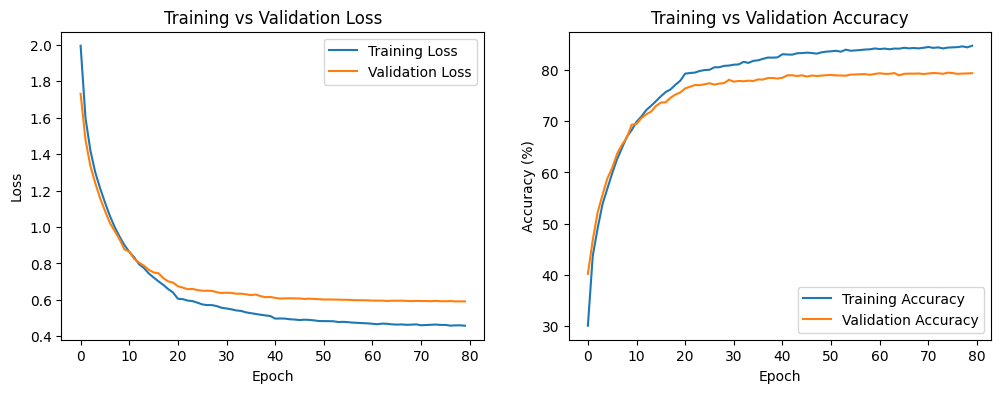

In [7]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

#### Test Accuracy Using Swish

In [8]:

model.eval()  # Set the model to evaluation mode
test_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_set)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7889


### Observation:
Achieved Test Acc : 78.89%, almost close to the initial implementation but it is apparent that the SELU implementation resulted in a more desirable convergence